# Cross-sectional temperature/ salinity anomalies

- construct Gem like mean by averaging temperatures along a contour for each depth level
- calculate anomalies for each level by substracting mean

## Setup

In [1]:
from IPython.display import HTML
# %run _setup.py
import os
figsdir = os.path.join(os.sep, 'g', 'data', 'v45', 'jm6603', 'checkouts', 'phd-figs', 'manuscripts', '02_manuscript')

import cosima_cookbook as cc
import climtas.nci

from dask.distributed import Client

import xarray as xr
import numpy as np
import xgcm
import pandas as pd
from datetime import datetime, timedelta

import pyproj
from oceanpy import Contour, haversine

from gsw import sigma0, t_from_CT, SA_from_SP, p_from_z, geo_strf_dyn_height
import gsw

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib import animation
%matplotlib inline

import cmocean as cmo
import string

savefig=False

fs_small = 20
fs_large = 22
plt.rc('text', usetex=True)
plt.rc('xtick',labelsize=fs_small)
plt.rc('ytick',labelsize=fs_small)
plt.rc('axes', labelsize=fs_large)
plt.rcParams['text.latex.preamble'] = [
    r'\usepackage{amsmath}',
    r'\usepackage{amsfonts}',
    r'\usepackage{amssymb}']
plt.rc('text', usetex=False)

In [2]:
def coord_cross(along_section, coord_sel):
    idx = np.argmin([haversine([ln, coord_sel[0]], [lt, coord_sel[1]])[0]
                     for ln, lt in zip(along_section.xt_ocean, along_section.yt_ocean)])
    return along_section['along-section'][idx]

def display_animation(anim):
    plt.close(anim._fig)
    return HTML(anim.to_html5_video())

In [3]:
def gem_lookup_table(ds, bins, sea_level='sea_level'):
    
    # select front from sea level field
    ds_front = ds.where((ds[sea_level] >= bins.min()) & (ds[sea_level] <= bins.max()))
    
    # group data in sea levels bins and average profiles in each bin
    gem = ds.groupby_bins(sea_level, bins=bins).mean()
    
    # make lookup table to find in which bin a certain sea level lies
    df = pd.IntervalIndex(gem.sea_level_bins.data)
    lookup_table = pd.DataFrame({'intervals': df, 'left': df.left, 'right': df.right})
    
    return gem, lookup_table


# function to find gem profile for given sea level
def find_gem_profile(sea_level, gem, lookup_table):
    
    idx = np.where((sea_level > lookup_table.left) & (sea_level <= lookup_table.right))[0]
    if idx.size == 0:
#         raise ValueError('Sea level does not exist in look up table')
        return gem.isel(sea_level_bins = 0)*np.nan
    else:
        return gem.isel(sea_level_bins = idx)

def gem_section(ds, gem, lookup_table, sea_level='sea_level', section_name='section'):
    
    gem_section = []
    for sl in ds[sea_level]:
        gem_section.append(find_gem_profile(sl.values, gem, lookup_table).squeeze())
    gem_section = xr.concat(gem_section, dim=section_name)
    gem_section = gem_section.assign_coords({section_name: ds[section_name]})
    
    return gem_section

def var_to_density(ds, grd=None, var='CT', density='sigma0', depth='st_ocean'):
    
    if grd is None:
        grd = np.linspace(ds[density].min(), ds[density].max(), ds[depth].size)
    
    var = ds[var].chunk({depth: None})
    target_data = ds[density].chunk({depth: None})
    
    return grid.transform(var, 'Z', grd, target_data=target_data)

# def var_to_zi(ds, grd=None, var='CT', depth='st_ocean', depth_var='z'):
    
#     if grd is None:
#         grd = np.linspace(ds[depth].min(), ds[depth].max(), ds[depth].size)
    
#     var = ds[var].chunk({depth: None})
#     target_data = ds[depth_var].chunk({depth: None})
    
#     ds_zi = grid.transform(var, 'Z', grd, target_data=target_data)
#     ds_zi.coords[depth_var].attrs.update(axis='Z')

#     return ds_zi

def var_to_zm(ds_depth, ds_density, depth='z', density='sigma0', section_name='section'):# var='CT'

    ds_zm = []
    for i in range(ds_depth[section_name].size):
        
        vari = ds_depth[i]
        target_data = vari[depth]

        coord = ds_density.zm[i].drop_vars('sea_level_bins')
        ds_zm.append(grid.transform(vari, 'Z', -coord, target_data=target_data))

    ds_zm = xr.concat(ds_zm, dim=section_name)
    ds_zm = ds_zm.assign_coords({section_name: ds_density[section_name]})
    
    return ds_zm

def anomalies_on_density(ds, ds_gem, variables=('CT', 'SA', 'z'), density_grd=None, depth_grd=None, section_name='section'):
    
    # interpolate variables on density grid and determine anomalies
    ds_on_density = xr.Dataset()
    for var in variables:
        ds_on_density[var] = var_to_density(ds, var=var, grd=density_grd)
        ds_on_density[var + '_gem'] = var_to_density(ds_gem, var=var, grd=density_grd)
        ds_on_density[var + '_gem'].name = var + '_gem'
        ds_on_density[var + '_anom_on_isop'] = ds_on_density[var] - ds_on_density[var + '_gem']
        ds_on_density[var + '_anom_on_isop'].name = var + '_anom_on_isop'

    # interpolate on uniform (z-grid) and non-uniform (zm-grid)
    ds_on_density['zm'] = (ds_on_density['z'] + ds_on_density['z_gem']) / 2
    ds_on_density['zm'].name = 'zm'
    
    for var in variables[0:2]:
        ds_var, ds_var_gem = ds[var].chunk({'st_ocean': None}), ds_gem[var].chunk({'st_ocean': None}).drop_vars('sea_level_bins')
        # interpolate variables on uniform grid
        # var_zi = var_to_zi(ds, var=var, depth_var='st_ocean', grd=depth_grd)
        # var_zi_gem = var_to_zi(ds_gem, var=var, depth_var='st_ocean', grd=depth_grd)
        # var_zi_gem = var_zi_gem.drop_vars('sea_level_bins')

        # calculate vertical gradient
        dvardz_gem = ds_var_gem.differentiate('st_ocean')

        # interpolate variables on non-uniform grid
        ds_on_density['%s_zm' % var] = var_to_zm(ds_var, ds_on_density, depth='st_ocean', section_name=section_name)
        ds_on_density['%s_gem_zm' % var] = var_to_zm(ds_var_gem, ds_on_density, depth='st_ocean', section_name=section_name)
        # ds_on_density['%s_zm' % var] = var_to_zm(var_zi, ds_on_density, depth='st_ocean', section_name='along-section')
        # ds_on_density['%s_gem_zm' % var] = var_to_zm(var_zi_gem, ds_on_density, depth='st_ocean', section_name='along-section')
        ds_on_density['%s_anom_zm' % var] = ds_on_density['%s_zm' % var] - ds_on_density['%s_gem_zm' % var]
        ds_on_density['d%sdz_gem' % var] = var_to_zm(dvardz_gem, ds_on_density, depth='st_ocean', section_name=section_name)
        ds_on_density['%s_anom_isop_disp' % var] = ds_on_density['z_anom_on_isop'] * ds_on_density['d%sdz_gem' % var]
        
        ds_on_density['%s_residual' %var] = (ds_on_density['%s_anom_zm' %var] - 
                                        (ds_on_density['%s_anom_on_isop' %var] + ds_on_density['%s_anom_isop_disp'%var]))
    
    return ds_on_density
    

def anomalies_on_depth(ds, ds_on_density, variables=('CT', 'SA'), density='sigma0', depth='st_ocean'):
    
    ds_on_density.coords[density].attrs.update(axis='Z')

    grid = xgcm.Grid(ds_on_density, periodic=False, boundary='extend')
    target_data = -ds_on_density['z']
    
    ds_on_depth = xr.Dataset()
    for var in variables:
        ds_on_depth['%s_anom_on_isop' %var] = grid.transform(ds_on_density['%s_anom_on_isop' %var], 'Z', ds[depth], target_data=target_data)
        ds_on_depth['%s_anom_isop_disp' %var] = grid.transform(ds_on_density['%s_anom_isop_disp' %var], 'Z', ds[depth], target_data=target_data)
        
    return ds_on_depth


In [4]:
database = '/g/data/ik11/databases/cosima_master.db'
session = cc.database.create_session(db=database)

expt = '01deg_jra55v140_iaf'

In [5]:
# client = climtas.nci.GadiClient()
# client
client = Client(n_workers=8, memory_limit='180GB')
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/41711/status,
Dashboard: /proxy/41711/status,Workers: 8
Total threads: 16,Total memory: 359.38 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:38307,Workers: 8
Dashboard: /proxy/41711/status,Total threads: 16
Started: Just now,Total memory: 359.38 GiB
Comm: tcp://127.0.0.1:42861,Total threads: 2
Dashboard: /proxy/39257/status,Memory: 44.92 GiB
Nanny: tcp://127.0.0.1:37959,


## Load data

In [6]:
# data output frequency
freq = '1 daily'

# time limits of dataset
start, end = '1997-04-01', '1997-04-30'
start, end = '1997-04-18', '1997-04-20'

# start_lim, end_lim = '1999-05-01', '1999-05-31'
time_lim = slice(start, end)

In [7]:
sl = cc.querying.getvar(expt=expt, variable='sea_level', session=session, frequency=freq, start_time=start, end_time=end)
u = cc.querying.getvar(expt=expt, variable='u', session=session, frequency=freq, start_time=start, end_time=end)
v = cc.querying.getvar(expt=expt, variable='v', session=session, frequency=freq, start_time=start, end_time=end)
wt = cc.querying.getvar(expt=expt, variable='wt', session=session, frequency=freq, start_time=start, end_time=end)

temp = cc.querying.getvar(expt=expt, variable='temp', session=session, frequency=freq, start_time=start, end_time=end)
salt = cc.querying.getvar(expt=expt, variable='salt', session=session, frequency=freq, start_time=start, end_time=end)

geolat_t = cc.querying.getvar(expt,'geolat_t', session=session, n=1)
geolon_t = cc.querying.getvar(expt,'geolon_t', session=session, n=1)

# load topography
ht = cc.querying.getvar(expt=expt, variable='ht', session=session, frequency='static', n=1)

## Select regional data

In [8]:
# location limits of dataset
lon_lim = slice(-224, -212)
lat_lim = slice(-53.5, -47.5)
flex_period = slice('1997-04-10', '1997-04-25')

sl_lim = sl.sel(xt_ocean=lon_lim, yt_ocean=lat_lim)
u_lim = u.sel(xu_ocean=lon_lim, yu_ocean=lat_lim)
v_lim = v.sel(xu_ocean=lon_lim, yu_ocean=lat_lim)
wt_lim = wt.sel(xt_ocean=lon_lim, yt_ocean=lat_lim)

temp_lim = temp.sel(xt_ocean=lon_lim, yt_ocean=lat_lim)
salt_lim = salt.sel(xt_ocean=lon_lim, yt_ocean=lat_lim)

lat_t = geolat_t.sel(xt_ocean=lon_lim, yt_ocean=lat_lim)
lon_t = geolon_t.sel(xt_ocean=lon_lim, yt_ocean=lat_lim)

ht_lim = ht.sel(xt_ocean=lon_lim, yt_ocean=lat_lim)

## Calculate GSW variables

In [9]:
hydro = xr.merge([temp_lim, salt_lim])
hydro = hydro.sel(time=flex_period)

In [10]:
st_ocean = hydro.st_ocean.values
yt_ocean = hydro.yt_ocean.values
xt_ocean = hydro.xt_ocean.values
time = hydro.time.values

lat_t_3d = np.broadcast_to(lat_t, st_ocean.shape + (lat_t.shape))
z_3d = np.broadcast_to(-st_ocean, lat_t_3d.T.shape).T

z = xr.DataArray(z_3d, 
                 coords = [st_ocean, yt_ocean, xt_ocean],
                 dims = ['st_ocean', 'yt_ocean', 'xt_ocean'],
                 name = 'z',
                 attrs = {'standard_name': 'sea_water_depth', 'units':'m'})

pressure = xr.DataArray(p_from_z(z_3d, lat_t_3d), 
                        coords = [st_ocean, yt_ocean, xt_ocean], 
                        dims = ['st_ocean', 'yt_ocean', 'xt_ocean'],
                        name = 'pressure',
                        attrs = {'standard_name': 'sea_water_pressure', 'units':'dbar'})
SA = xr.DataArray(SA_from_SP(hydro.salt, pressure, lon_t, lat_t), 
                  coords = [time, st_ocean, yt_ocean, xt_ocean], 
                  dims = ['time', 'st_ocean', 'yt_ocean', 'xt_ocean'], 
                  name = 'SA', 
                  attrs = {'standard_name': 'sea_water_absolute_salinity', 'units':'g kg-1'})

CT = hydro.temp-273
CT.name = 'CT'
CT.attrs.update(units='degC')

sig0 = sigma0(SA, CT)
sig0.name = 'sigma0'
sig0.attrs.update(standard_name='sea_water_potential_density')
sig0.attrs.update(units='kg m-3')

# density contours
watermass = {
    'ML': (np.nan, 26.75),
    'SAMW': (26.75, 26.95),
    'AAIW': (26.95, 27.25, 27.5),
    'UCDW': (27.5, 27.75),
    'LCDW': (27.75, 28.27),
    'AABW': (28.27, 28.5) # water with a <0 potential temperature
}
density_levels = np.unique(np.concatenate([value for value in watermass.values()]))

mid_density_levels= [26.85, 27.1, 27.375, 27.625, 27.8]

### Merge hydro and velocity datasets

In [11]:
hydro = xr.merge([z, pressure, CT, SA, sig0])

In [12]:
vel = xr.merge([sl_lim, u_lim, v_lim, wt_lim, ht_lim])
vel = vel.sel(time=flex_period)

ds = xr.merge([hydro, vel])

In [13]:
core_contour = -0.4

sl_contours = np.linspace(-0.3, 0.3, 7) + core_contour
u_contours = np.linspace(-0.1, 0.7, 5)
# vn_contours = np.linspace(-.25, .25, 6)
# vn_contours = [-0.08, -0.04, 0, 0.04, 0.08]
vn_contours = [-0.04, 0, 0.04]
wt_contours = [-5e-4, -3e-4, -1e-4,  1e-4,  3e-4, 5e-4]
slc = slice(None, None, 2)

## Make grid

In [14]:
ds.coords['xt_ocean'].attrs.update(axis='X')
ds.coords['xu_ocean'].attrs.update(axis='X', c_grid_axis_shift=0.5,periodic=False)
ds.coords['yt_ocean'].attrs.update(axis='Y')
ds.coords['yu_ocean'].attrs.update(axis='Y', c_grid_axis_shift=0.5)
ds.coords['st_ocean'].attrs.update(axis='Z')
ds.coords['sw_ocean'].attrs.update(axis='Z', c_grid_axis_shift=0.5)

grid = xgcm.Grid(ds, periodic=False, boundary='extend')#, periodic=['X']
grid

<xgcm.Grid>
Z Axis (not periodic, boundary='extend'):
  * center   st_ocean --> right
  * right    sw_ocean --> center
Y Axis (not periodic, boundary='extend'):
  * center   yt_ocean --> inner
  * inner    yu_ocean --> center
X Axis (not periodic, boundary='extend'):
  * center   xt_ocean --> right
  * right    xu_ocean --> center

In [15]:
u_grd = grid.interp(grid.interp(ds.u, 'X'), 'Y')
v_grd = grid.interp(grid.interp(ds.v, 'X'), 'Y')
w_grd = grid.interp(ds.wt, 'Z')
u_grd.name, v_grd.name, w_grd.name = 'u', 'v', 'wt'
ds['u'], ds['v'], ds['wt'], ds['wt_inv'] = u_grd, v_grd, w_grd, -w_grd

In [16]:
flex_period

slice('1997-04-10', '1997-04-25', None)

In [17]:
ds = ds.sel(time=flex_period).mean('time')
ds = ds.drop_vars(['xu_ocean', 'yu_ocean', 'sw_ocean'])
ds = ds.assign_coords(xt_ocean=((ds.xt_ocean + 180) % 360) - 180)


## Make cross contour sections

In [18]:
cont = Contour(ds, coords=('xt_ocean', 'yt_ocean'))
cont.get_coords(contour_name='sea_level', contour_value=core_contour, interp=True, spacing=20000)

along_section = cont.along_section(var_name=('sea_level'), coords=('xt_ocean', 'yt_ocean'), 
                                   section_name='along-section')

# across contour sections
UTM54 = pyproj.Proj('EPSG:32754')
npnts = 10
spacing = 20000 # m

coord_trough =(-222.55, -50.4)
cross_section_trough = cont.cross_section(
    coord_sel=coord_trough, transform=UTM54, npnts=npnts, spacing=spacing,
    coords=('xt_ocean', 'yt_ocean'), var_name=('u', 'v'), decompose=True)

coord_trough2 =(-222.2, -50)
cross_section_trough2 = cont.cross_section(
    coord_sel=coord_trough2, transform=UTM54, npnts=npnts, spacing=spacing,
    coords=('xt_ocean', 'yt_ocean'), var_name=('u', 'v'), decompose=True)

coord_trough3 =(-220.95, -50)
cross_section_trough3 = cont.cross_section(
    coord_sel=coord_trough3, transform=UTM54, npnts=npnts, spacing=spacing,
    coords=('xt_ocean', 'yt_ocean'), var_name=('u', 'v'), decompose=True)

coord_between =(-219.7, -50.25)
cross_section_between = cont.cross_section(
    coord_sel=coord_between, transform=UTM54, npnts=npnts, spacing=spacing,
    coords=('xt_ocean', 'yt_ocean'), var_name=('u', 'v'), decompose=True)

coord_between2 =(-219, -51)
cross_section_between2 = cont.cross_section(
    coord_sel=coord_between2, transform=UTM54, npnts=npnts, spacing=spacing,
    coords=('xt_ocean', 'yt_ocean'), var_name=('u', 'v'), decompose=True)

coord_between3 =(-219, -51.7)
cross_section_between3 = cont.cross_section(
    coord_sel=coord_between3, transform=UTM54, npnts=npnts, spacing=spacing,
    coords=('xt_ocean', 'yt_ocean'), var_name=('u', 'v'), decompose=True)

coord_crest =(-217.6, -51.8)
cross_section_crest = cont.cross_section(
    coord_sel=coord_crest, transform=UTM54, npnts=npnts, spacing=spacing,
    coords=('xt_ocean', 'yt_ocean'), var_name=('u', 'v'), decompose=True)

coord_crest2 =(-215.8, -51.5)
cross_section_crest2 = cont.cross_section(
    coord_sel=coord_crest2, transform=UTM54, npnts=npnts, spacing=spacing,
    coords=('xt_ocean', 'yt_ocean'), var_name=('u', 'v'), decompose=True)

coord_crest3 =(-214.5, -51)
cross_section_crest3 = cont.cross_section(
    coord_sel=coord_crest3, transform=UTM54, npnts=npnts, spacing=spacing,
    coords=('xt_ocean', 'yt_ocean'), var_name=('u', 'v'), decompose=True)

cross_sections = {
    'cross_section_trough': cross_section_trough, 
    'cross_section_trough2': cross_section_trough2, 
    'cross_section_trough3': cross_section_trough3, 
    'cross_section_between': cross_section_between, 
    'cross_section_between2': cross_section_between2, 
    'cross_section_between3': cross_section_between3, 
    'cross_section_crest': cross_section_crest,
    'cross_section_crest2': cross_section_crest2,
    'cross_section_crest3': cross_section_crest3
}

cross_coords = {
    'cross_section_trough': ['tab:blue', ':'], 
    'cross_section_trough2': ['tab:blue', '-'], 
    'cross_section_trough3': ['tab:blue', '--'], 
    'cross_section_between': ['tab:orange', ':'], 
    'cross_section_between2': ['tab:orange', '-'], 
    'cross_section_between3': ['tab:orange', '--'], 
    'cross_section_crest': ['tab:green', ':'],
    'cross_section_crest2': ['tab:green', '-'],
    'cross_section_crest3': ['tab:green', '--']
}

(136.00000000000358,
 148.00000000000296,
 -53.520843818326696,
 -47.48979973786345)

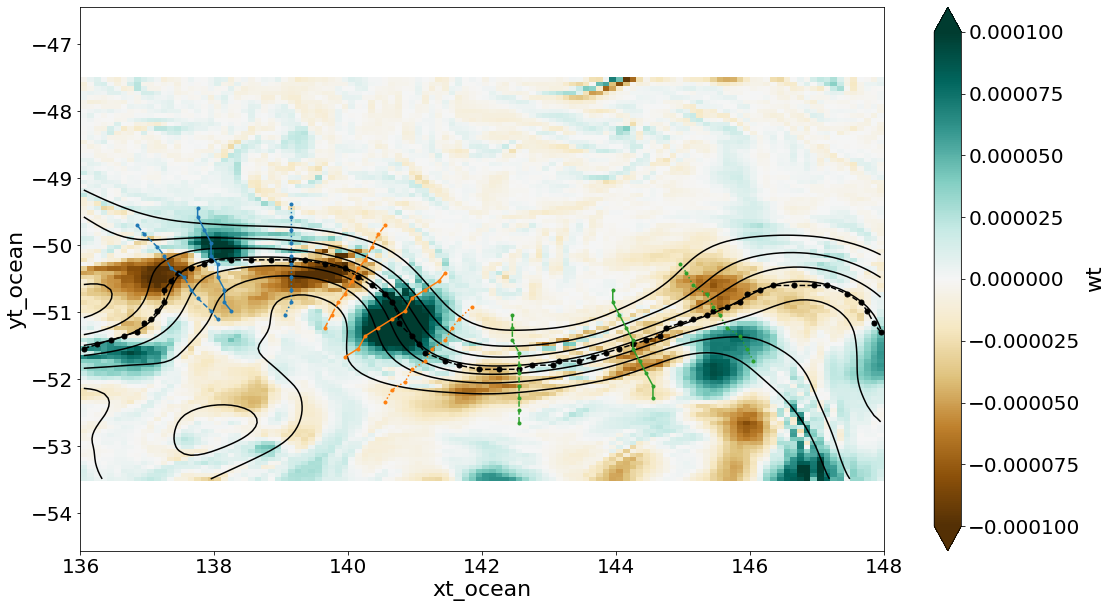

In [19]:
fig, ax = plt.subplots(figsize=(18,10))
ds.wt.isel(st_ocean=30).plot(ax=ax,vmin=-1e-4, vmax=1e-4, cmap=plt.cm.BrBG)
ds.sea_level.plot.contour(levels=sl_contours, colors='k', linestyles='solid')
ax.plot(along_section.xt_ocean, along_section.yt_ocean, '.--', color='k', markersize=10)
ax.plot(cross_section_trough.xt_ocean, cross_section_trough.yt_ocean, '.--', color='tab:blue')
ax.plot(cross_section_trough2.xt_ocean, cross_section_trough2.yt_ocean, '.-', color='tab:blue')
ax.plot(cross_section_trough3.xt_ocean, cross_section_trough3.yt_ocean, '.:', color='tab:blue')
ax.plot(cross_section_between.xt_ocean, cross_section_between.yt_ocean, '.--', color='tab:orange')
ax.plot(cross_section_between2.xt_ocean, cross_section_between2.yt_ocean, '.-', color='tab:orange')
ax.plot(cross_section_between3.xt_ocean, cross_section_between3.yt_ocean, '.:', color='tab:orange')
ax.plot(cross_section_crest.xt_ocean, cross_section_crest.yt_ocean, '.--', color='tab:green')
ax.plot(cross_section_crest2.xt_ocean, cross_section_crest2.yt_ocean, '.-', color='tab:green')
ax.plot(cross_section_crest3.xt_ocean, cross_section_crest3.yt_ocean, '.:', color='tab:green')
ax.axis('equal')
# plt.show()

## make GEM cross sections


In [20]:
hydro_front = ds.drop_vars(['u', 'v', 'wt', 'ht', 'wt_inv'])
bins = np.linspace(-0.6, -0.1, 101)

# construct gem and lookup table for profiles in associated sea level bin
gem, lookup_table = gem_lookup_table(hydro_front, bins)

# make gem sections for each cross section
density_grd = np.linspace(26.555, 27.835, 76)
depth_grd = np.linspace(cross_sections['cross_section_trough'].st_ocean.min(), 
                        cross_sections['cross_section_trough'].st_ocean.max(), 
                        cross_sections['cross_section_trough'].st_ocean.size)

cross_sections_gem, cross_sections_on_density, cross_sections_on_z = {}, {}, {}
for name, data in cross_sections.items():
    cross_sections_gem[name] = gem_section(data, gem, lookup_table, section_name='cross-section')

    cross_sections_on_density[name] = anomalies_on_density(data, cross_sections_gem[name], 
                                                density_grd=density_grd, depth_grd=depth_grd, section_name='cross-section')

    cross_sections_on_z[name] = anomalies_on_depth(data, cross_sections_on_density[name])

### on pressure levels

In [21]:
cs_sel = cross_sections_on_density['cross_section_between2'].sel(sigma0=27.75, method='nearest')

In [22]:
cs_sel

<xarray.Dataset>
Dimensions:            (cross-section: 10)
Coordinates:
    yt_ocean           (cross-section) float64 dask.array<chunksize=(10,), meta=np.ndarray>
    xt_ocean           (cross-section) float64 dask.array<chunksize=(10,), meta=np.ndarray>
  * cross-section      (cross-section) float64 0.0 1.953e+04 ... 1.785e+05
    sigma0             float64 27.75
    sea_level_bins     (cross-section) object dask.array<chunksize=(10,), meta=np.ndarray>
Data variables: (12/22)
    CT                 (cross-section) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    CT_gem             (cross-section) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    CT_anom_on_isop    (cross-section) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    SA                 (cross-section) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    SA_gem             (cross-section) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    SA_anom_on_isop    (cross-section) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    ...                 ...
    SA_zm              (cross-section) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    SA_gem_zm          (cross-section) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    SA_anom_zm         (cross-section) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    dSAdz_gem          (cross-section) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    SA_anom_isop_disp  (cross-section) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    SA_residual        (cross-section) float64 dask.array<chunksize=(1,), meta=np.ndarray>

In [23]:
for cs_name in cross_sections:
    print(cs_name)

cross_section_trough
cross_section_trough2
cross_section_trough3
cross_section_between
cross_section_between2
cross_section_between3
cross_section_crest
cross_section_crest2
cross_section_crest3


cross_section_trough


/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.01/lib/python3.9/site-packages/numba/np/ufunc/gufunc.py:170: RuntimeWarning: invalid value encountered in _interp_1d_linear
  return self.ufunc(*args, **kwargs)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.01/lib/python3.9/site-packages/numba/np/ufunc/gufunc.py:170: RuntimeWarning: invalid value encountered in _interp_1d_linear
  return self.ufunc(*args, **kwargs)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.01/lib/python3.9/site-packages/numba/np/ufunc/gufunc.py:170: RuntimeWarning: invalid value encountered in _interp_1d_linear
  return self.ufunc(*args, **kwargs)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.01/lib/python3.9/site-packages/numba/np/ufunc/gufunc.py:170: RuntimeWarning: invalid value encountered in _interp_1d_linear
  return self.ufunc(*args, **kwargs)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.01/lib/python3.9/site-packages/numba/np/ufunc/gufunc.py:170: RuntimeWarning: invalid value 

cross_section_trough2
cross_section_trough3
cross_section_between
cross_section_between2
cross_section_between3
cross_section_crest
cross_section_crest2
cross_section_crest3


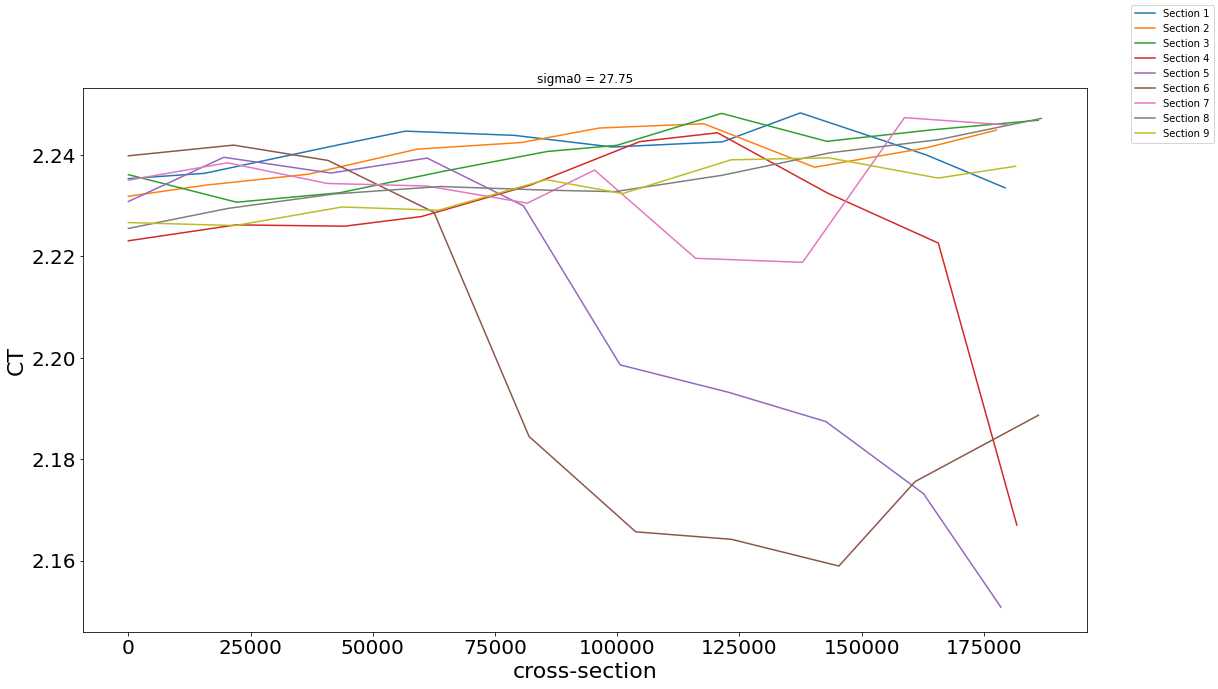

In [24]:
fig, ax=plt.subplots(figsize=(18,10))
for i, cs_name in enumerate(cross_sections):
    print(cs_name)
    cs_sel = cross_sections_on_density[cs_name].sel(sigma0=27.75, method='nearest')
    cs_sel.CT.plot(ax=ax, label='Section %s' %(i+1))
# cs_sel.CT_gem.plot(ax=ax[0], label='CT_gem')
# cs_sel.SA.plot(ax=ax[1], label='SA_gem')
# cs_sel.SA_gem.plot(ax=ax[1], label='SA_gem')
fig.legend()

In [25]:
var_attrs = {
    'CT' : [cmo.cm.thermal, 1, 9, r'$\left.\Theta^\prime\right|_{z}$'],
    'CT_anom_zm' : [cmo.cm.balance, -1, 1, r'$\left.\Theta^\prime\right|_{z_m}$'],
    'CT_gem' : [cmo.cm.thermal, 1, 9, ''],
    'CT_anom_on_isop': [cmo.cm.balance, -.35, .35, r'$\left.\Theta^\prime\right|_{\sigma}$'],
    'CT_anom_isop_disp': [cmo.cm.balance, -1, 1, r'$- \left.h^\prime\right|_{\sigma} \left.\frac{\partial\Theta^{GEM}}{\partial z}\right|_{\sigma}$'],
    'dCTdz_gem': [cmo.cm.balance, -0.1, 0.1, r'$\left.\frac{\partial\Theta^{GEM}}{\partial z}\right|_{\sigma}$'],
    'SA': [cmo.cm.haline, 34.0, 34.9, ''],
    'SA_zm': [cmo.cm.haline, 34.0, 34.9, ''],
    'SA_gem': [cmo.cm.haline, 34.0, 34.9, ''],
    'SA_anom_on_isop': [cmo.cm.delta, -0.1, 0.1, ''],
    'SA_anom_isop_disp': [cmo.cm.delta, -0.1, 0.1, ''],
    'dSAdz_gem': [cmo.cm.delta, -0.1, 0.1, ''],
    'h_anom': [cmo.cm.diff, -80, 80, r'$\left.h^\prime\right|_{\sigma}$']
}

In [26]:
plt.rcParams.update(plt.rcParamsDefault)

In [27]:
# name = 'cross_section_between3'

# fig, ax= plt.subplots(figsize=(10,10))

# cross_sections_on_z[name][var].plot(x='cross-section', 
#         cmap=var_attrs[var][0], vmin=var_attrs[var][1], vmax=var_attrs[var][2])

# cross_sections[name].vn.plot(ax=ax, x='cross-section', vmin=-0.5, vmax=0.5, cmap=plt.cm.RdBu)

# quiv = cross_sections[name].sel(st_ocean=slc).plot.quiver(ax=ax, color='gray',
#     x='cross-section', y='st_ocean', u='vn', v='wt_inv', angles='xy', scale_units='inches', scale=0.5, add_guide=False)

# ax.invert_yaxis()
# qk = plt.quiverkey(quiv, 0.5, 0.1, 0.5, r'$0.5\:\mathrm{ms}^{-1}$', labelpos='E', coordinates='figure', 
#                    fontproperties={'size': fs_large})

In [28]:
plt.rcParams.update({"text.usetex": True, "font.family": 'serif', "font.serif": 'cm', 'font.size': fs_small})

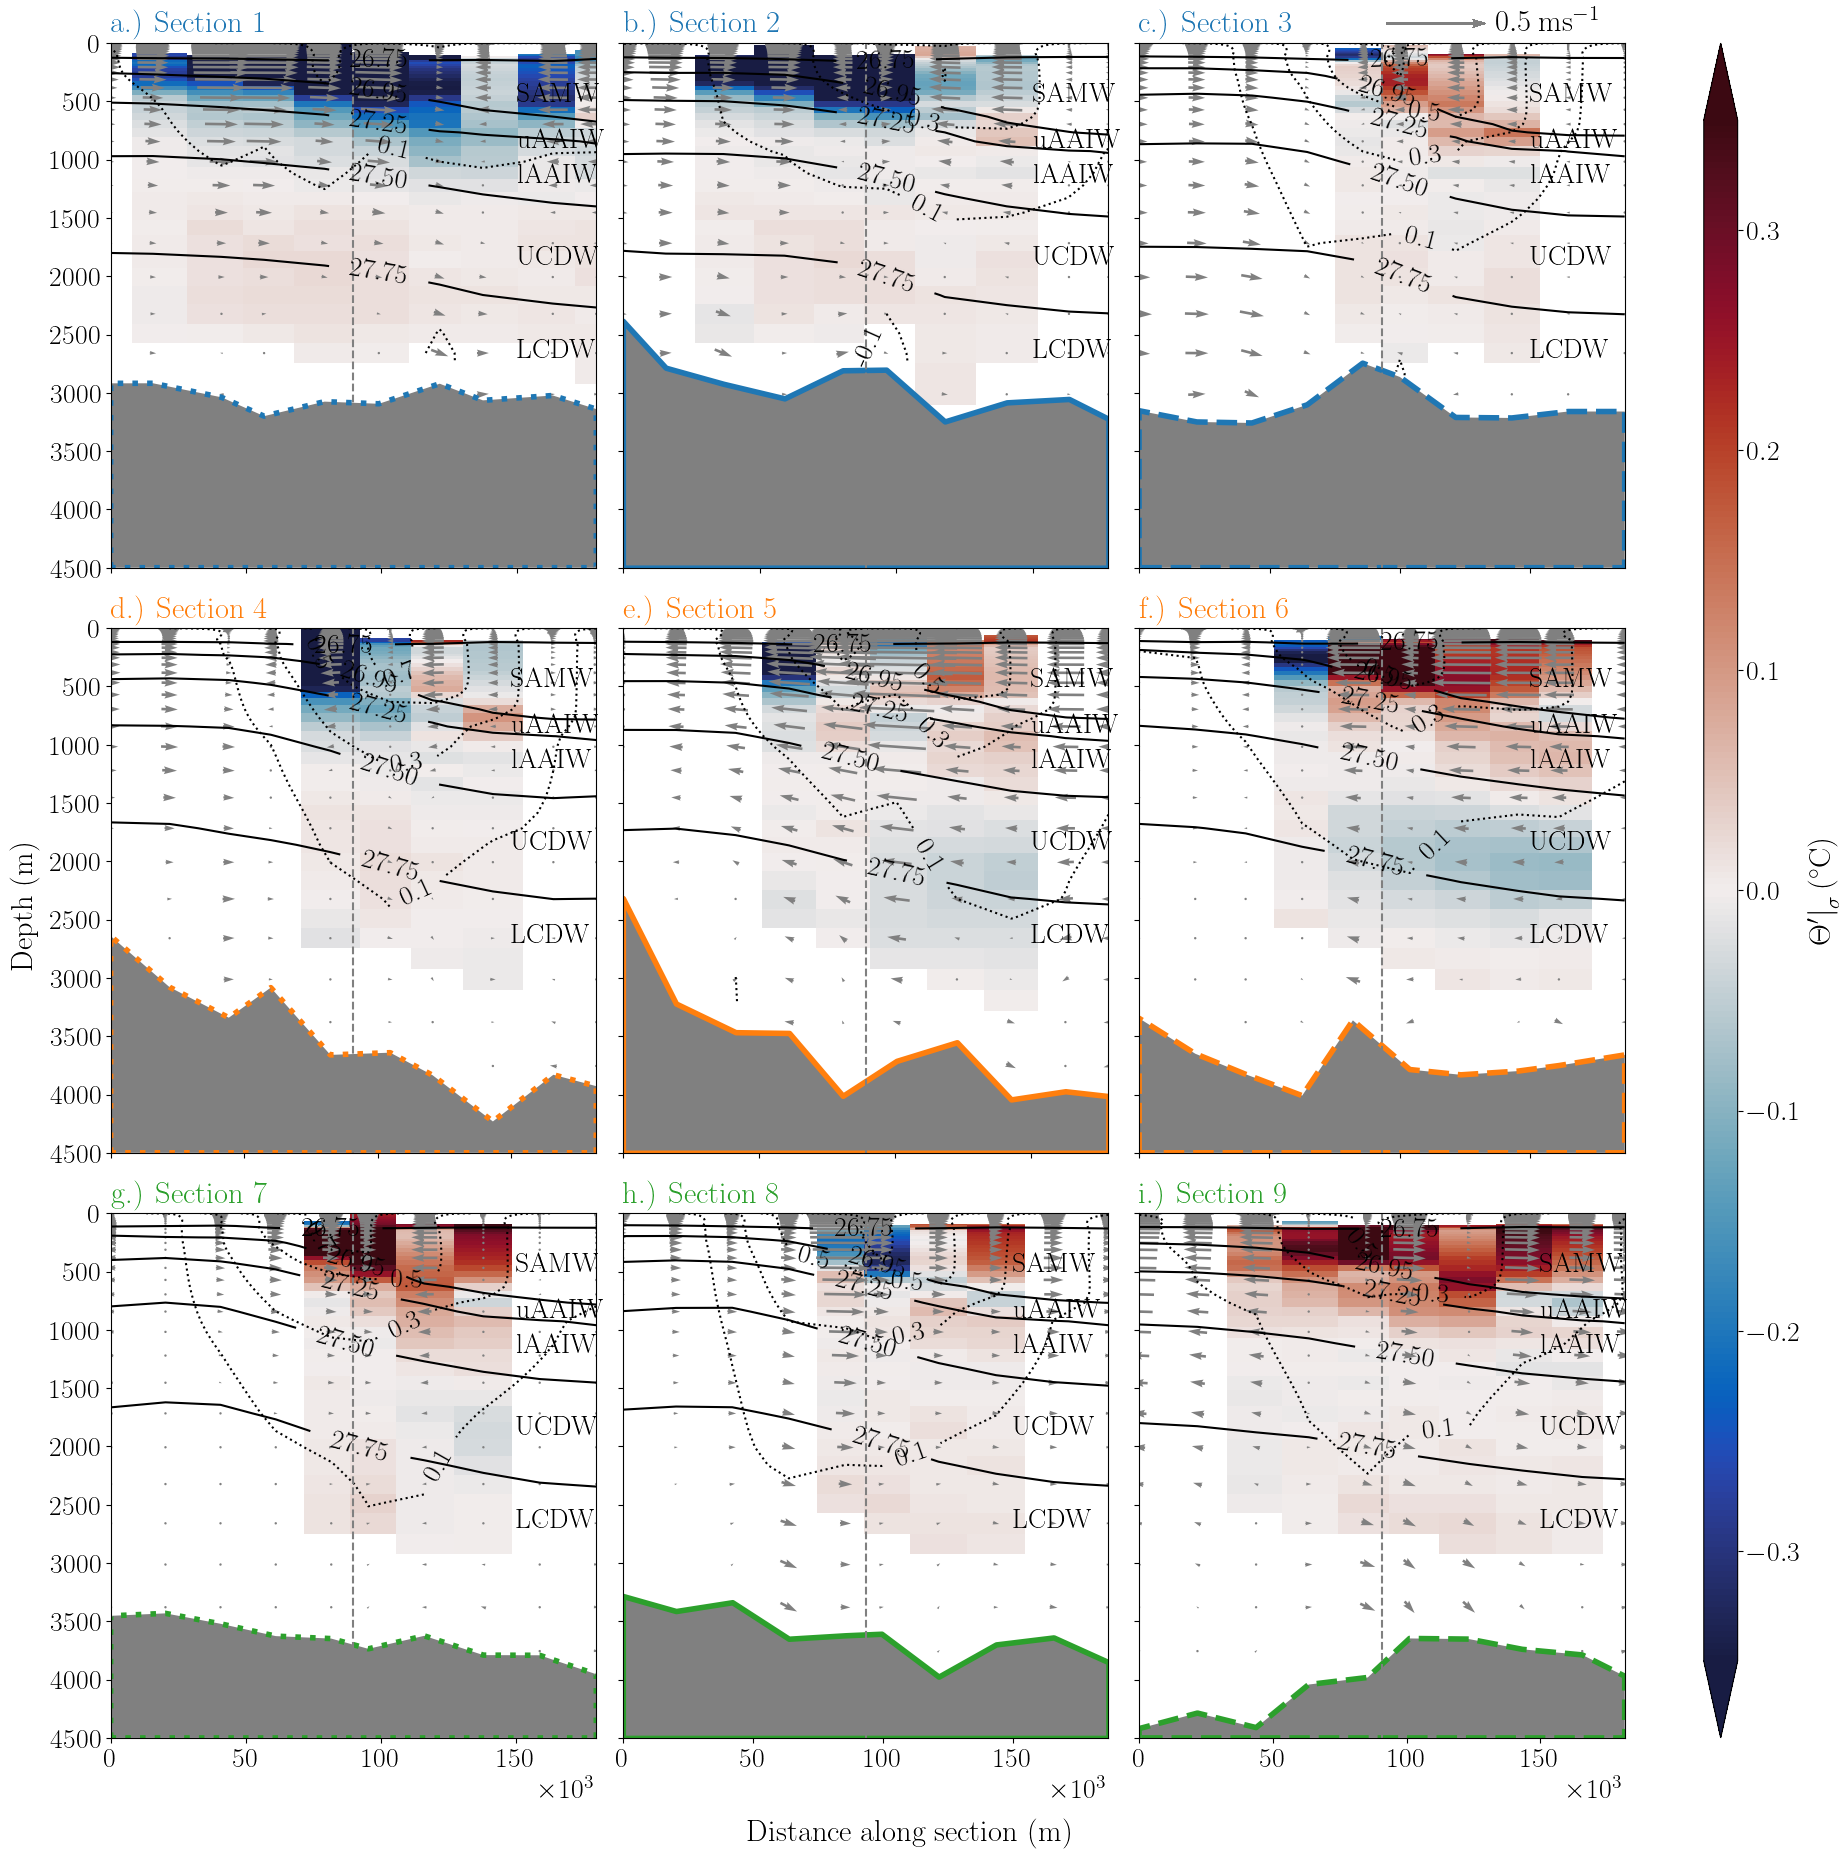

In [29]:
var = 'CT_anom_on_isop'

nrows, ncols = 3, 3
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(18,18), constrained_layout=True, sharey=True)

manual_locations = {
    0: [(110e3, 500)],
    1: [(75e3, 2500), (110e3, 1500), (110e3, 700)],
    2: [(110e3, 1500), (110e3, 1000), (110e3, 500)],
    3: [(110e3, 2000), (110e3, 1000), (110e3, 500), (75e3, 250)],
    4: [(110e3, 2000), (110e3, 1000), (110e3, 500)],
    5: [(110e3, 1750), (110e3, 750), (90e3, 500)],
    6: [(110e3, 2000), (110e3, 1000), (110e3, 500), (75e3, 250)],
    7: [(110e3, 2000), (110e3, 1000), (110e3, 500), (75e3, 250)],
    8: [(110e3, 1500), (110e3, 750), (85e3, 250)]
}

for iax, (name, data) in enumerate(cross_sections.items()):

    r, c = iax // ncols, iax % ncols

    # vertical along and cross sectional velocities
    pcol = cross_sections_on_z[name][var].plot(
        ax=ax[r, c], x='cross-section', 
        cmap=var_attrs[var][0], vmin=var_attrs[var][1], vmax=var_attrs[var][2], add_colorbar=False)
    ct = cross_sections[name].ut.plot.contour(
        ax=ax[r, c], x='cross-section', colors='k', levels=u_contours, linestyles='dotted')

    quiv = cross_sections[name].sel(st_ocean=slc).plot.quiver(ax=ax[r, c], color='gray',
        x='cross-section', y='st_ocean', u='vn', v='wt_inv', angles='xy', scale_units='inches', scale=0.5, width=3e-4*fig.get_size_inches()[0], add_guide=False)

    # density contours
    cont = cross_sections[name].sigma0.plot.contour(
        ax=ax[r, c], x='cross-section', levels=density_levels, colors='k')
    ax[r, c].clabel(cont, inline=1, fmt='%.2f', inline_spacing=10, use_clabeltext=True, fontsize=fs_small)

    wm = {'SAMW': (150e3, 500), 
          'uAAIW': (150e3, 900), 
          'lAAIW': (150e3, 1200), 
          'UCDW': (150e3, 1900),
          'LCDW': (150e3, 2700)}
    for key, [x, y] in wm.items():
        ax[r, c].text(x, y, key, fontsize=fs_small)
        
    # topography
    ax[r, c].fill_between(cross_sections[name]['cross-section'], cross_sections[name].ht, 4500,
                          fc='gray', ec=cross_coords[name][0], 
                          lw=4, linestyle=cross_coords[name][1])
    
    # core of front
    ax[r, c].axvline((cross_sections[name]['cross-section'].min() + cross_sections[name]['cross-section'].max()) / 2, linestyle='--', color='gray')
    
    ax[r, c].set_ylim([0,4500])
    ax[r, c].set_xlim([cross_sections[name]['cross-section'].min(), cross_sections[name]['cross-section'].max()])
    if r != 2:
        ax[r, c].set_xticklabels('', fontsize=fs_small)
    else:
        ax[r, c].ticklabel_format(axis="x", style="sci", scilimits=(3, 3))

    ax[r, c].invert_yaxis()
    
    ax[r, c].clabel(ct, inline=1, fmt='%.1f', inline_spacing=10, use_clabeltext=True, fontsize=fs_small, manual=manual_locations[iax])
    
    ax[r, c].set_xlabel('')
    ax[r, c].set_ylabel('')
    
    # labelling
    ax[r, c].text(0, 1.02, string.ascii_lowercase[iax] + '.) Section %s' %(iax+1), 
                  transform=ax[r, c].transAxes, size=fs_large, weight='bold', color=cross_coords[name][0])

fig.text(0.48, -0.02, r'Distance along section (m)', ha='center', fontsize=fs_large)
fig.text(-0.02, 0.5, r'Depth (m)', va='center', rotation='vertical', fontsize=fs_large)

cbar = fig.colorbar(pcol, ax=ax, aspect=50, extend='both')
cbar.ax.set_ylabel(r'$\left . {\Theta^\prime} \right |_\sigma (^\circ\mathrm{C})$', fontsize=fs_large)

qk = plt.quiverkey(quiv, 0.8, 0.99, 0.5, r'$0.5\:\mathrm{ms}^{-1}$', labelpos='E', coordinates='figure', 
                   fontproperties={'size': fs_large})

In [33]:
if savefig:
    extensions = ['.png', '.pdf', '.eps']
    for extension in extensions:
        transparent = True if extension == '.png' else False
        fig.savefig(os.path.join(figsdir, '05_temp-anomalies-on-isop-cross' + extension), 
                    transparent=transparent, bbox_inches='tight')

### on density levels

In [ ]:
plt.rcParams.update(plt.rcParamsDefault)

In [ ]:
# var = 'dCTdz_gem'
var = 'CT_anom_on_isop'

nrows, ncols = 3, 3
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(18,18), constrained_layout=True, sharey=True)

for iax, (name, data) in enumerate(cross_sections.items()):

    r, c = iax // ncols, iax % ncols
    
    # ds_var = cross_sections_on_density[name]['%s_zm'%var] - (cross_sections_on_density[name]['%s'%var] + cross_sections_on_density[name]['%s_isop_disp'%var])
    ds_var = cross_sections_on_density[name][var]
    # vertical along and cross sectional velocities
    pcol = ds_var.plot(
        ax=ax[r, c], x='cross-section', y='sigma0',
        cmap=var_attrs[var][0], vmin=var_attrs[var][1], vmax=var_attrs[var][2], add_colorbar=False) 
    # ct = cross_sections[name].ut.plot.contour(ax=ax[r, c], x='cross-section', colors='k', levels=u_contours, linestyles='dotted')
    # ax[r, c].clabel(ct, inline=1, fmt='%.1f', inline_spacing=10, use_clabeltext=True)
    
    ct = cross_sections_on_density[name].z.plot.contour(
        ax=ax[r, c], x='cross-section', y='sigma0', levels=[-500, -1000, -1500, -2500],
        colors='gray', linestyles='solid')
    ax[r, c].clabel(ct, inline=1, fmt='%.0f', inline_spacing=10, use_clabeltext=True)
    cross_sections_on_density[name].z_gem.plot.contour(
        ax=ax[r, c], x='cross-section', y='sigma0', levels=[-500, -1000, -1500, -2500], 
        linestyles='dashed', colors='gray')

    # cross_sections[name].sel(st_ocean=slc).plot.quiver(ax=ax[r, c], color='gray',
    #     x='cross-section', y='st_ocean', u='vn', v='wt_inv', angles='xy', scale_units='xy', scale=1e-5)

#     # density contours
    wm_strs = ['SAMW', 'uAAIW', 'lAAIW', 'UCDW', 'LCDW']
    for dl, mid, wm in zip(density_levels[:-3], mid_density_levels, wm_strs):
        ax[r, c].axhline(dl, color='k')
        ax[r, c].text(2500, mid, wm, fontsize=fs_large)
    
    ax[r, c].invert_yaxis()    
    ax[r, c].set_xlabel('')
    ax[r, c].set_ylabel('')
    
fig.text(0.48, -0.02, r'Distance along section (m)', ha='center', fontsize=fs_large)
fig.text(-0.02, 0.5, r'Potential density, $\sigma_0$ (kgm$^{-3}$)', va='center', rotation='vertical', fontsize=fs_large)
    
cbar = fig.colorbar(pcol, ax=ax, aspect=50, extend='both')
cbar.ax.set_ylabel(var_attrs[var][3], fontsize=fs_large)


/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.07/lib/python3.9/site-packages/numba/np/ufunc/gufunc.py:151: RuntimeWarning: invalid value encountered in _interp_1d_linear
  return self.ufunc(*args, **kwargs)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.07/lib/python3.9/site-packages/numba/np/ufunc/gufunc.py:151: RuntimeWarning: invalid value encountered in _interp_1d_linear
  return self.ufunc(*args, **kwargs)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.07/lib/python3.9/site-packages/numba/np/ufunc/gufunc.py:151: RuntimeWarning: invalid value encountered in _interp_1d_linear
  return self.ufunc(*args, **kwargs)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.07/lib/python3.9/site-packages/numba/np/ufunc/gufunc.py:151: RuntimeWarning: invalid value encountered in _interp_1d_linear
  return self.ufunc(*args, **kwargs)


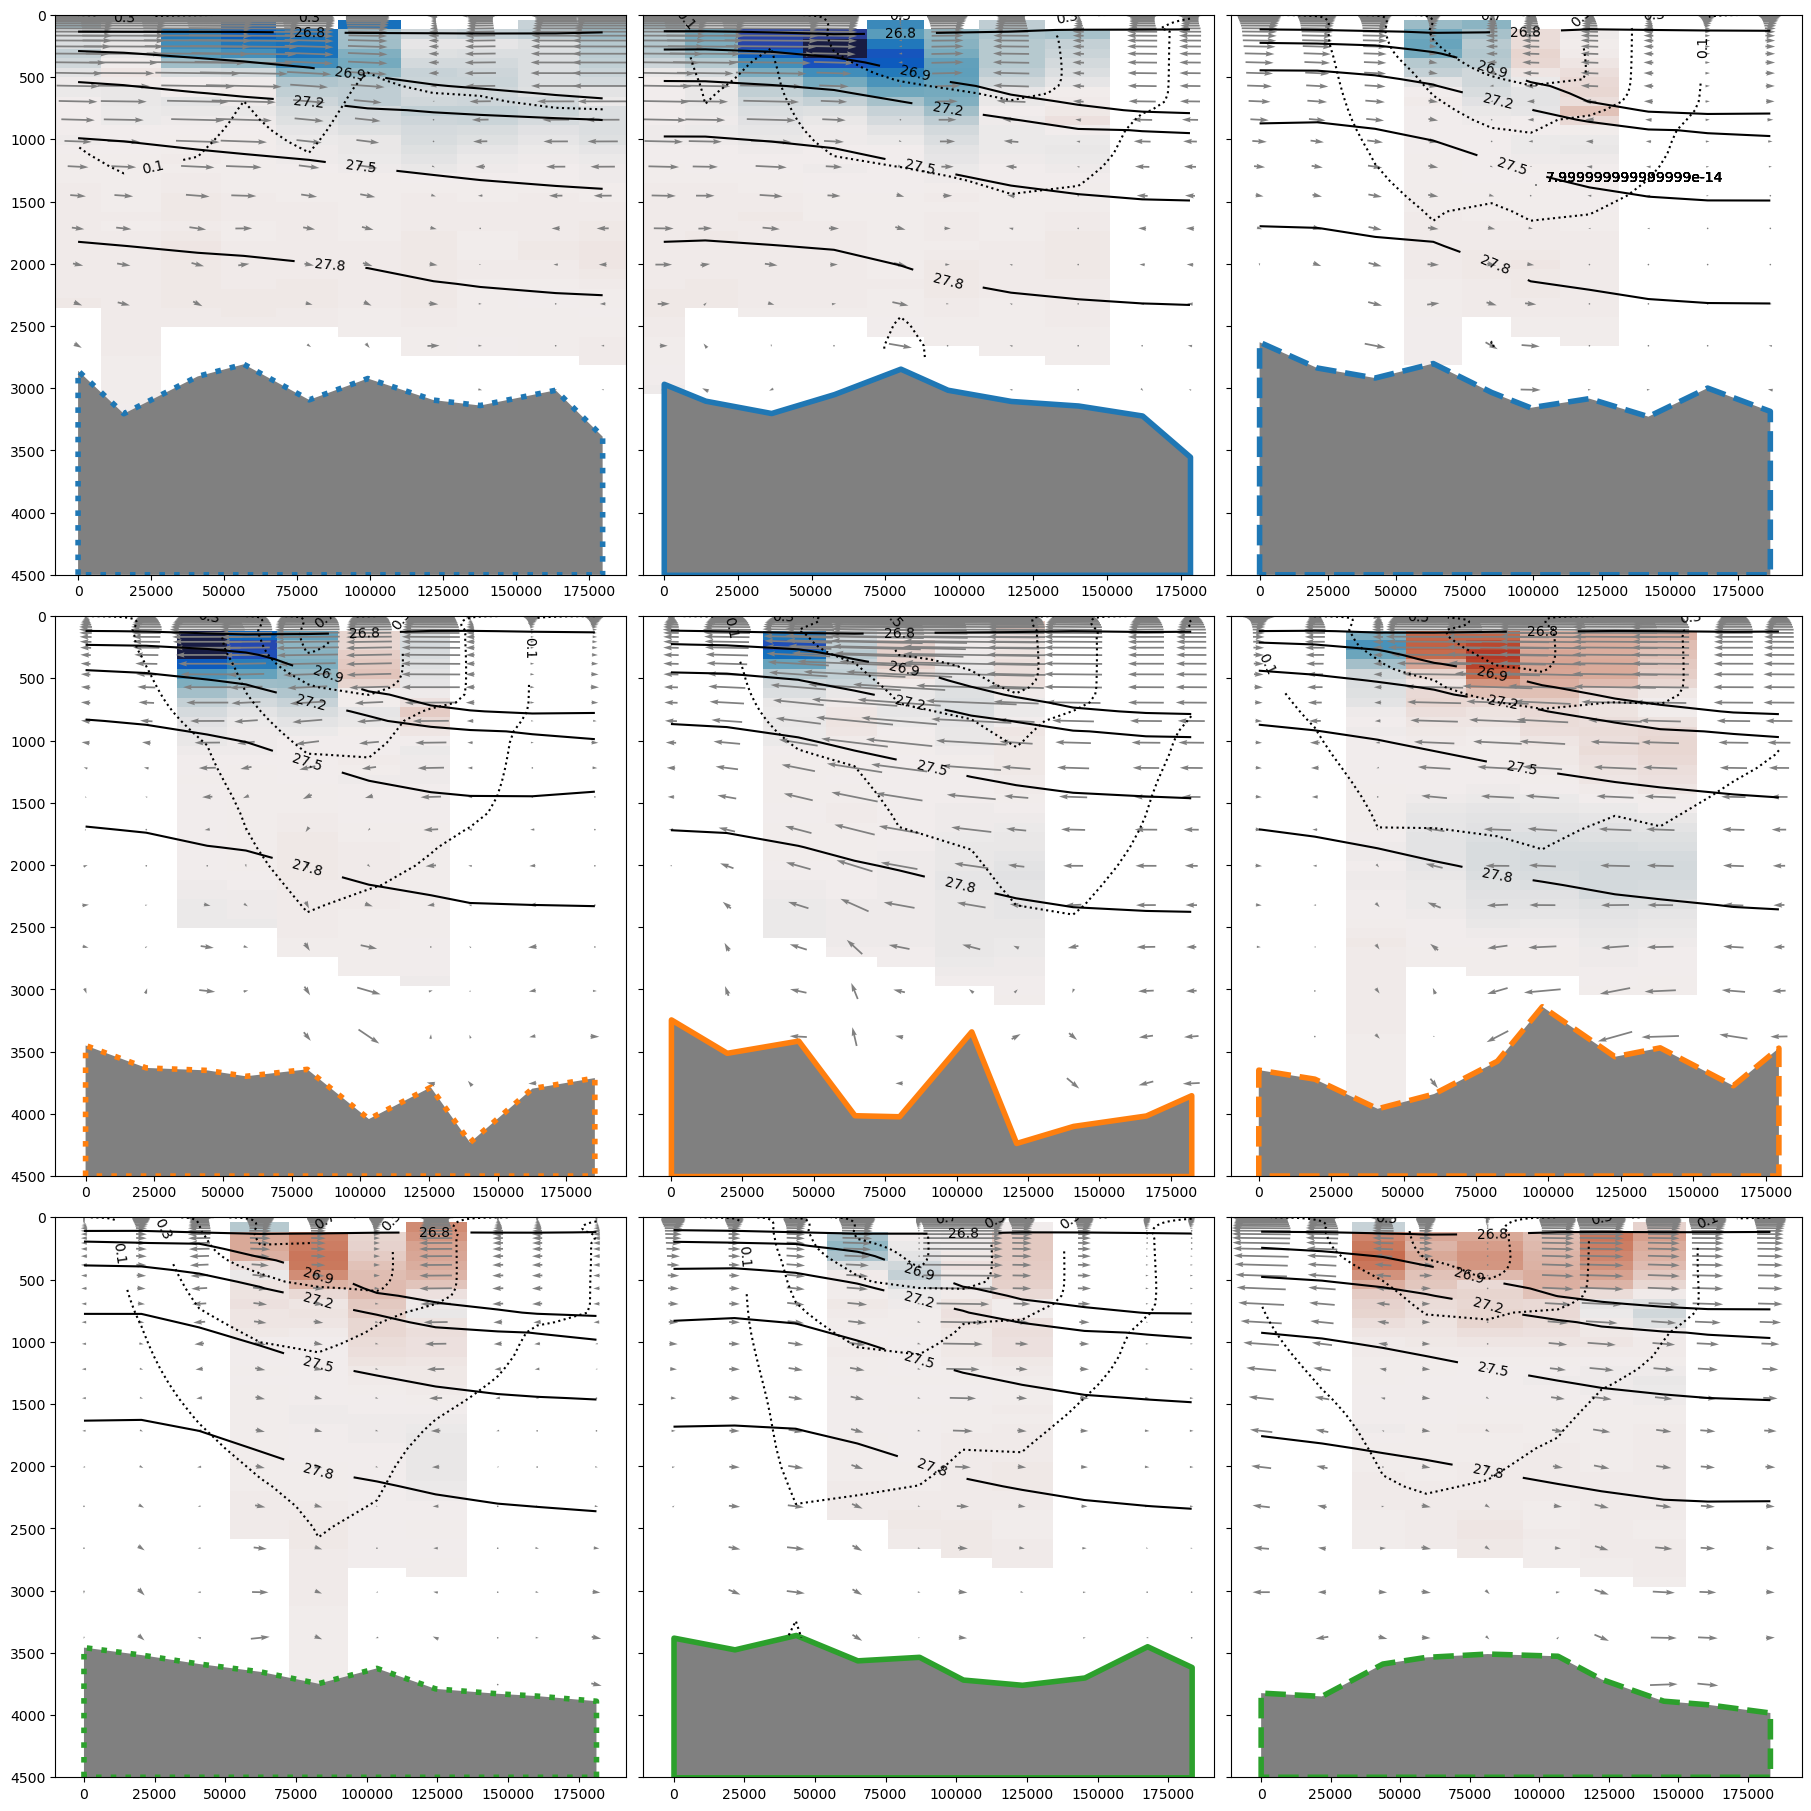

In [28]:
var = 'CT_anom'

nrows, ncols = 3, 3
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(18,18), constrained_layout=True, sharey=True)

for iax, (name, data) in enumerate(cross_sections.items()):
    
    ds_var = cross_sections_on_z[name][var+'_on_isop']
    
    r, c = iax // ncols, iax % ncols

    # vertical along and cross sectional velocities
    pcol = ds_var.plot(
        ax=ax[r, c], x='cross-section', 
        cmap=var_attrs[var][0], vmin=var_attrs[var][1], vmax=var_attrs[var][2], add_colorbar=False)
    ct = cross_sections[name].ut.plot.contour(
        ax=ax[r, c], x='cross-section', colors='k', levels=u_contours, linestyles='dotted')
    ax[r, c].clabel(ct, inline=1, fmt='%.1f', inline_spacing=10, use_clabeltext=True)

    cross_sections[name].sel(st_ocean=slc).plot.quiver(ax=ax[r, c], color='gray',
        x='cross-section', y='st_ocean', u='vn', v='wt_inv', angles='xy', scale_units='xy', scale=1e-5)

    # density contours
    cont = cross_sections[name].sigma0.plot.contour(
        ax=ax[r, c], x='cross-section', levels=density_levels, colors='k')
    ax[r, c].clabel(cont, inline=1, fmt='%.1f', inline_spacing=10, use_clabeltext=True)

    # topography
    ax[r, c].fill_between(cross_sections[name]['cross-section'], cross_sections[name].ht, 4500,
                          fc='gray', ec=cross_coords['along-section-' + name[14:]][1], 
                          lw=4, linestyle=cross_coords['along-section-' + name[14:]][2])
    
    ax[r, c].set_ylim([0,4500])
    ax[r, c].invert_yaxis()
    
    ax[r, c].set_xlabel('')
    ax[r, c].set_ylabel('')

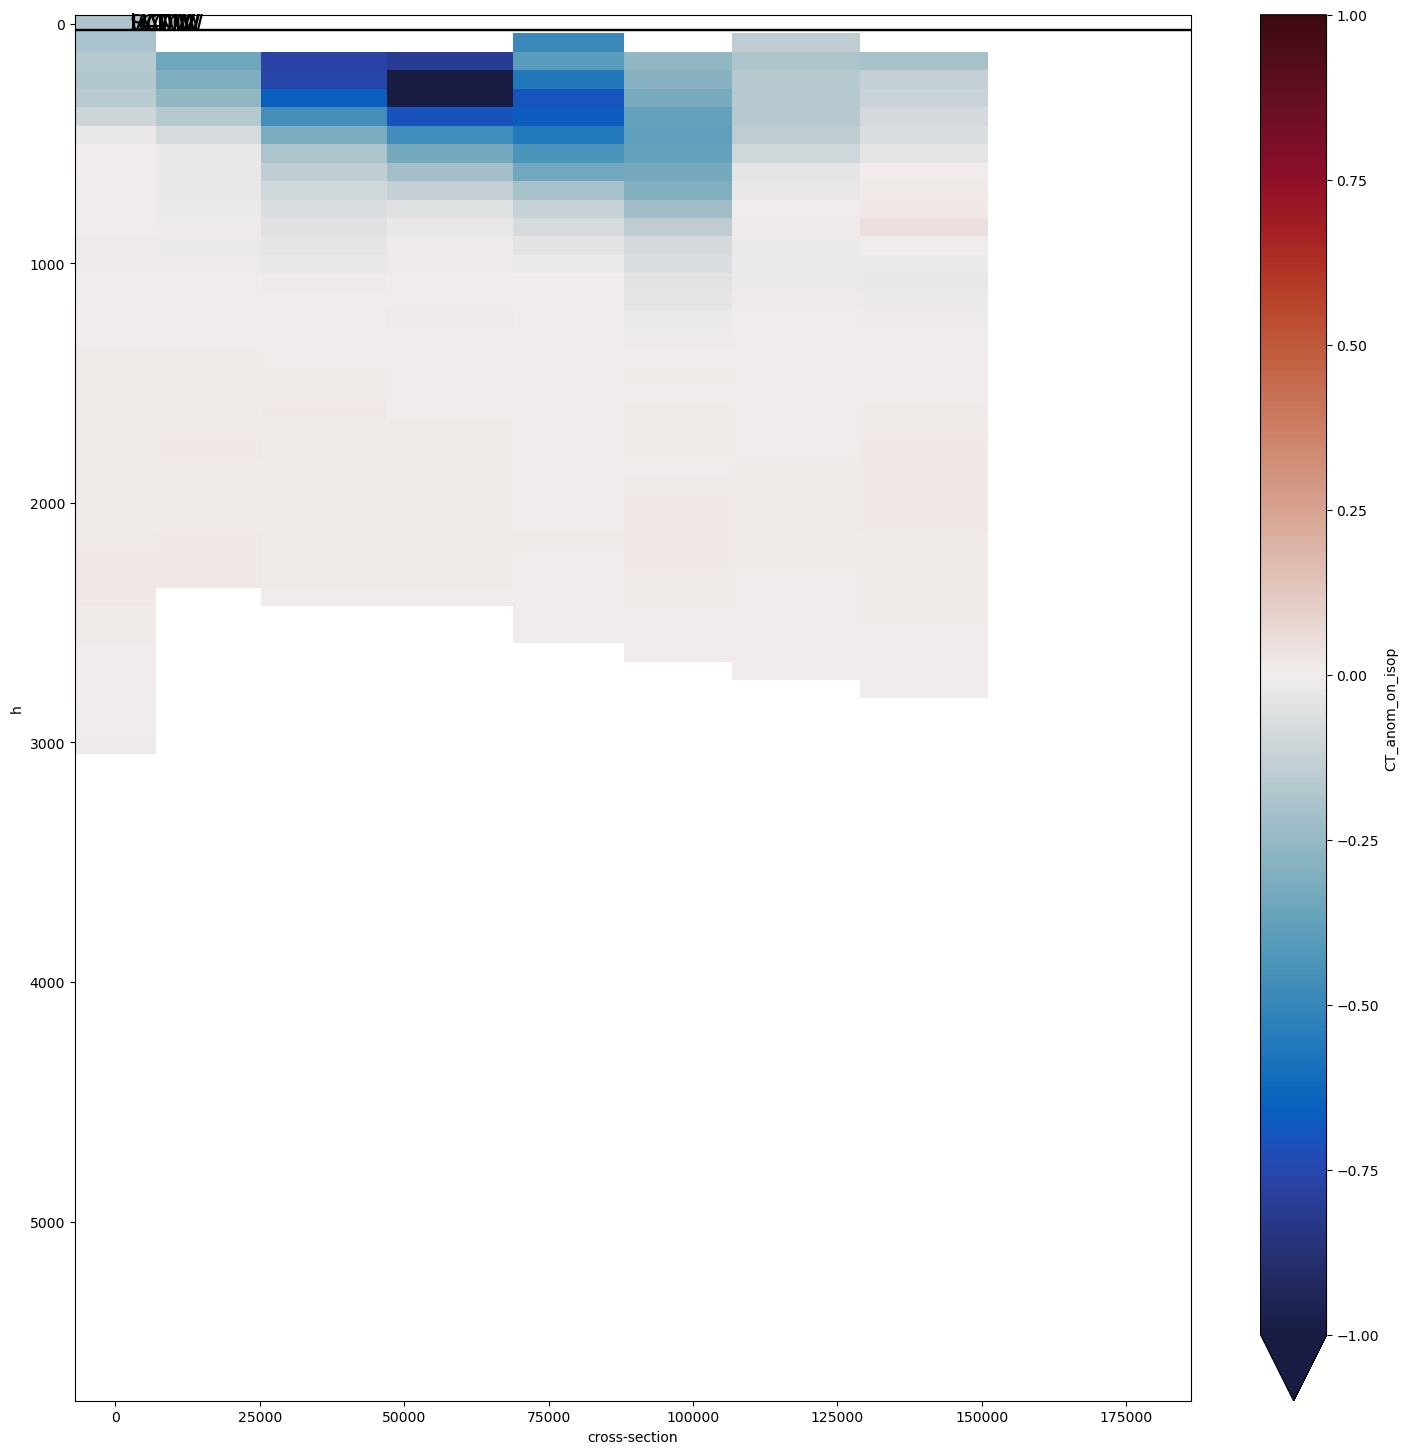

In [47]:
# name = 'cross_section_trough2'
# var = 'CT_anom'
# ds_var = cross_sections_on_z[name][var+'_on_isop']

# fig, ax = plt.subplots(figsize=(18,18))


#     r, c = iax // ncols, iax % ncols

#     # vertical along and cross sectional velocities
#     pcol = ds_var.plot(
#         ax=ax[r, c], x='cross-section', 
#         cmap=var_attrs[var][0], vmin=var_attrs[var][1], vmax=var_attrs[var][2], add_colorbar=False)
#     ct = cross_sections[name].ut.plot.contour(
#         ax=ax[r, c], x='cross-section', colors='k', levels=u_contours, linestyles='dotted')
#     ax[r, c].clabel(ct, inline=1, fmt='%.1f', inline_spacing=10, use_clabeltext=True)

#     cross_sections[name].sel(st_ocean=slc).plot.quiver(ax=ax[r, c], color='gray',
#         x='cross-section', y='st_ocean', u='vn', v='wt_inv', angles='xy', scale_units='xy', scale=1e-5)

#     # density contours
#     cont = cross_sections[name].sigma0.plot.contour(
#         ax=ax[r, c], x='cross-section', levels=density_levels, colors='k')
#     ax[r, c].clabel(cont, inline=1, fmt='%.1f', inline_spacing=10, use_clabeltext=True)

#     # topography
#     ax[r, c].fill_between(cross_sections[name]['cross-section'], cross_sections[name].ht, 4500,
#                           fc='gray', ec=cross_coords['along-section-' + name[14:]][1], 
#                           lw=4, linestyle=cross_coords['along-section-' + name[14:]][2])
    
#     ax[r, c].set_ylim([0,4500])
#     ax[r, c].invert_yaxis()
    
#     ax[r, c].set_xlabel('')
#     ax[r, c].set_ylabel('')